In [16]:
import pandas as pd
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

Для начала загрузим данные и excelевского файла, правильно проиндексируем по интересующему нас критерию "Персона" и кратко взглянем на то, что имеем

In [3]:
xl = pd.ExcelFile("Задача.xlsx")
df = xl.parse("Данные")
df.index = df.Персона
df = df.drop(['Персона'], axis=1)
df.head()

,"Возраст, лет","Стаж вождения, лет","Убыточность, %","Уровень заработной платы, руб/год"
Персона,,,,
6-LLJEH,20,1,263,716693
2-GLHFG,74,51,107,274393
6-FJFKL,27,1,165,723841
4-KJEJL,24,6,348,139419
5-JFFGH,26,3,286,650003


Теперь, когда наши данные загружены, есть два пути - работать с данными как они есть или нормализовать их. Ввиду того, что показатели в разных столбцах имеют разные порядки, то тут стоит выбрать второй случай, а именно нормализацию данных, которая реализуется при помощи стандартного метода StandardScaler. И только после этого можно будет задавать какой-то вопрос про кластеризацию. 
<br>Первый вопрос, который приходит в голову - это сколько же клатеров у нас получится. Ответ поможет нам найти "метод локтя", применимый для алгоритма KMeans. Подробное описание можно найти тут: <a href="https://habrahabr.ru/company/ods/blog/325654/">cтатья про кластеризацию на хабре</a>. Суть заключается в том, что этот алгоритм минимизирует параметр, называемый <i>inertia</i>. Эта самая inertia является дискретной фукцией относительно числа кластеров, и искомое число кластеров достигается в точке, где излом функции максимальный(угол между прозводными слева и справа).
<br>Также хочется объяснить почему выбран именно KMeans - этот алгоритм самый популярный, а данных у нас немного, поэтому он отлично справится.

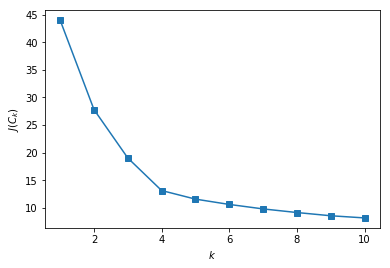

In [4]:
scaler = StandardScaler()
X = scaler.fit_transform(df)
inertia = []
for k in range(1,11):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(X)
    inertia.append(np.sqrt(kmeans.inertia_))

plt.plot(range(1, 11), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

Как видно из графика, искомое число кластеров - 4. Обучим наш алгоритм с найденным гиперпараметром. У этого алгортима есть атрибуты <i>cluster_centers_</i>, которые показывают, где находятся центры классов, и <i>labels_</i>, которые имеет смысл добавить в нашу таблицу к данным. Правда, чтобы понять смысл этих центров, придётся провести обратное отображение.

In [5]:
kmeans = KMeans(n_clusters=4, random_state=1).fit(X)
df['Класс'] = kmeans.labels_
centers = scaler.inverse_transform(kmeans.cluster_centers_)
centers.astype(np.int64)

array([[     69,      45,     152,  242958],
       [     24,       2,     209,  670466],
       [     56,      29,      65, 2978736],
       [     30,       7,     497,  149292]])

In [6]:
df.head()

,"Возраст, лет","Стаж вождения, лет","Убыточность, %","Уровень заработной платы, руб/год",Класс
Персона,,,,,
6-LLJEH,20,1,263,716693,1
2-GLHFG,74,51,107,274393,0
6-FJFKL,27,1,165,723841,1
4-KJEJL,24,6,348,139419,3
5-JFFGH,26,3,286,650003,1


По большей части задача уже решена, однако есть ещё несколько моментов, которые можно обсудить - дать логические названия классам, посчитать различные характеристики для людей из одного класса и как-нибудь визуализировать результат.
<br>
<ol>
    <li value="0">Люди пенсионного возраста с большим стажем вождения, со средней убыточностью и живущие на пенсию и прошлые накопления.
    <li>Молодые люди, недавно закончившие обучения, получили права и устроились на первуб работу. Довольно убыточны, ибо ветер в голове.
    <li>Люди предпенсионного возраста, как правило с высокой зарплатой и максимально надёжные.
    <li>Люди, которые впали в кризис среднего возраста, потеряли работу. Крайне убыточные клиенты.
</ol>

In [7]:
for cluster, sub_df in df.groupby(['Класс']):
    print(sub_df.drop(['Класс'], axis=1).describe())

       Возраст, лет  Стаж вождения, лет  Убыточность, %  \
count     121.00000          121.000000      121.000000   
mean       69.85124           45.826446      152.380165   
std         5.68721            6.113752       32.875334   
min        59.00000           33.000000       92.000000   
25%        65.00000           42.000000      128.000000   
50%        70.00000           46.000000      153.000000   
75%        74.00000           50.000000      180.000000   
max        79.00000           58.000000      209.000000   

       Уровень заработной платы, руб/год  
count                         121.000000  
mean                       242958.446281  
std                         24325.309127  
min                        200043.000000  
25%                        220775.000000  
50%                        243203.000000  
75%                        267884.000000  
max                        279472.000000  
       Возраст, лет  Стаж вождения, лет  Убыточность, %  \
count    128.000000   

Исходя из этой статистики можно заявить, что наше предположение про каждый из классов достаточно точно его отражает, разве что последний из классов можно переименовать в просто "безработных", причём чем старше они, тем более убыточны. Да и сами по себе классы получились довольно сбалансированными.

Теперь осталось лишь сделать результаты нагляднее - визуализируем центры наших классов при помощи '<i>bar</i>' графиков, и исходное множество при помощи метода <i>tsne</i> с числом главных компонет равным 2.

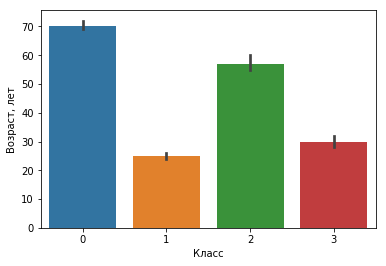

In [8]:
ax = sns.barplot(x="Класс", y="Возраст, лет", data=df, estimator=np.median)

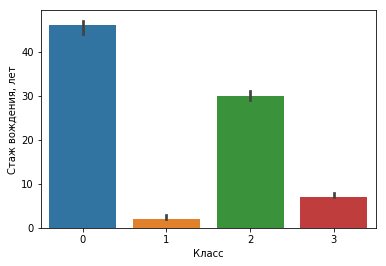

In [9]:
ax = sns.barplot(x="Класс", y="Стаж вождения, лет", data=df, estimator=np.median)

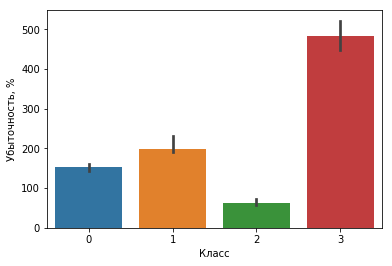

In [10]:
ax = sns.barplot(x="Класс", y="Убыточность, %", data=df, estimator=np.median)

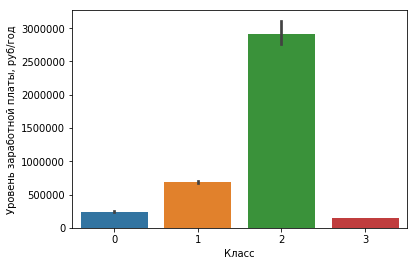

In [11]:
ax = sns.barplot(x="Класс", y="Уровень заработной платы, руб/год", data=df, estimator=np.median)

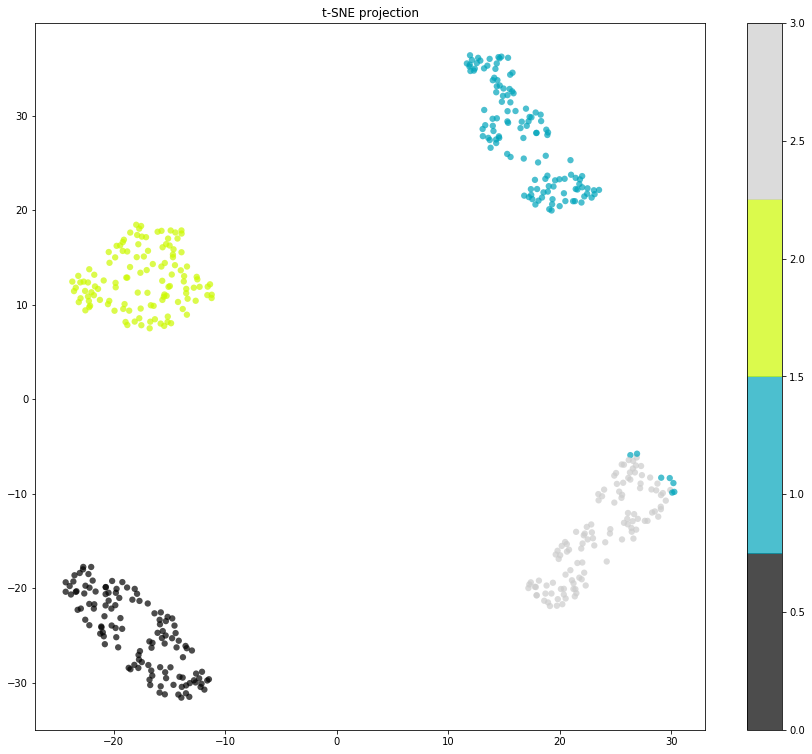

In [12]:
tsne = TSNE(n_components=2, random_state=1)
X_tsne = tsne.fit_transform(X)
plt.figure(figsize=(15,13))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=df.Класс, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 4))
plt.colorbar()
plt.title('t-SNE projection');

Как видно классы получились хорошо разделимыми, разве что студенты могли причислиться к классу безработных, что довольно логично. Тем не менее причину небольших расхождений можно обсудить подробнее. Скорее всего это связано с тем, что tsne не является алгоритмом кластеризации, а лишь способ визуализации многомерного множества. Отчасти он чем-то схож с PCA - теряя в размерности пр-ва, мы теряем часть информации. Ввиду этого какие-то важные признаки могли не учесться. Однако это может оказаться и ошибка KMeans. Чтобы это проверить возьмём ещё какой-нибудь алгоритм кластеризации, сравним их качество с предыдущим по метрике <i>silhouette</i> и построим новое tsne отображение.

KMeans score:  0.647782902611
AgglomerativeClustering score:  0.648423268458


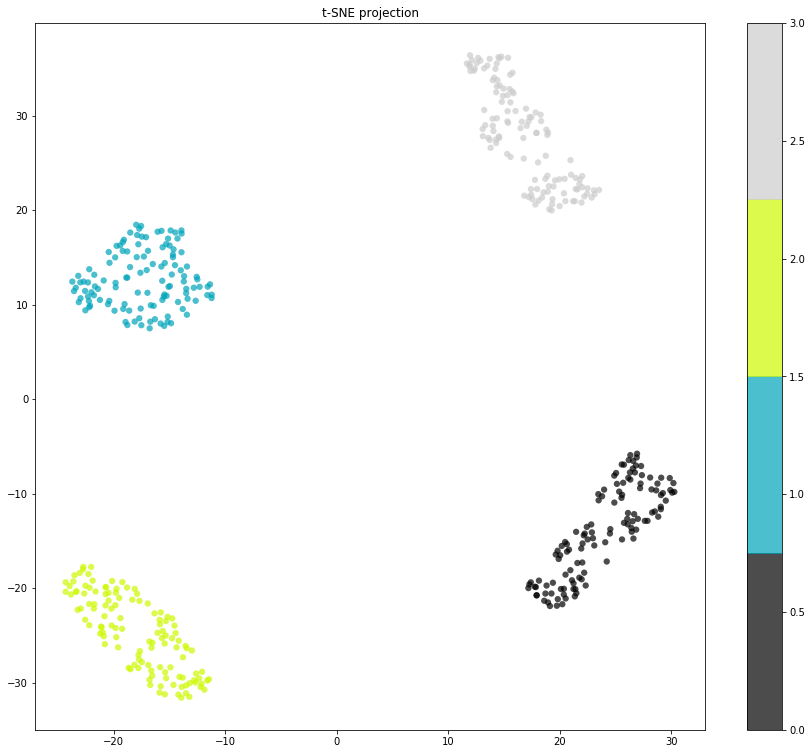

In [27]:
ac = AgglomerativeClustering(n_clusters = 4).fit(X)
print("KMeans score: ", metrics.silhouette_score(X, kmeans.labels_, metric='euclidean'))
print("AgglomerativeClustering score: ", metrics.silhouette_score(X, ac.labels_, metric='euclidean'))
df['Класс'] = ac.labels_
plt.figure(figsize=(15,13))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=df.Класс, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 4))
plt.colorbar()
plt.title('t-SNE projection');

Ввиду особенности метрики silhouette, чем больше её значение, тем лучше прошла кластеризация. Доказательство того, что второй алгоритм отработал чуть лучше можно увидеть на новой проекции, где не видно явных ошибок. Поэтому задачу можно считать решённой.